# Variational Autoencoder Image Generation on MNIST

In this notebook we wish to train a VAE on the MNIST images and evaluate the quality of reconstructed images 

In [62]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure as ssim
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Downloading the data:

In [2]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data',
                                     train = False,
                                     download = True,
                                     transform = transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████| 9.91M/9.91M [00:04<00:00, 2.28MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 166kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████| 1.65M/1.65M [00:14<00:00, 113kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 17.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
x_train = trainset.data.numpy()
x_val = testset.data[:1000].numpy()
x_test = testset.data[1000:].numpy()

## Dataset and Dataloaders:

In [4]:
class CustomDataset(Dataset):
    def __init__(self, img):
        self.img = img

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        return image

In [8]:
train_dataset = CustomDataset(x_train)
test_dataset = CustomDataset(x_test)
val_dataset = CustomDataset(x_val)


train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=32)
test_loader = DataLoader(test_dataset,
                          shuffle=True,
                          batch_size=32)
val_loader = DataLoader(val_dataset,
                        shuffle=True,
                        batch_size=32)

# Model definition:

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder_conv = nn.Sequential(  #Encoder
            nn.Conv2d(1, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(512, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_sigma = nn.Linear(128, 2)

        self.fc2 = nn.Linear(2, 256)  #Decoder
        self.fc3 = nn.Linear(256, 4 * 4 * 32)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (32, 4, 4)),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1),
            nn.Sigmoid()
        )


    def encoder(self, x):
        h = torch.tanh(self.fc1(self.encoder_conv(x)))
        return self.fc_mu(h), self.fc_sigma(h) # mu, std

    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc2(z))
        h = F.relu(self.fc3(h))
        h = self.decoder_conv(h)
        return h

    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

In [10]:
model = VAE()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

def loss_function(y, x, mu, std):
    bce_loss = nn.BCELoss(reduction='sum')
    ERR = bce_loss(y.view(-1, 784), x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + torch.log(std**2 + 1e-8) - mu**2 - std**2)

    return ERR + KLD, ERR, KLD

# Training loop:

In [11]:
train_err_loss, train_kld_loss, val_total_loss = [], [], []
model.to(device)

for epoch in range(1, 40):

    train_loss = 0
    model.train()
    for images in train_loader:

        images = images.to(device).unsqueeze(1).type(torch.float32) / 255

        reconstructed_batch, mu, std = model(images)
        loss, err, kld = loss_function(reconstructed_batch, images, mu, std)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += err.item() + kld.item()

        train_err_loss.append(err.item()/32)
        train_kld_loss.append(kld.item()/32)


    model.eval()
    val_loss = 0
    for images in val_loader:

        images = images.to(device).unsqueeze(1).type(torch.float32) / 255

        reconstructed_batch, mu, std = model(images)
        loss, err, kld = loss_function(reconstructed_batch, images, mu, std)
        val_loss += err.item() + kld.item()
        val_total_loss.append(val_loss/32)

    train_loss /= (len(train_loader) * 32)
    val_loss /= (len(val_loader) * 32)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}')


Epoch: 1 | Train loss: 183.5254 | Validation loss: 159.9111
Epoch: 2 | Train loss: 160.7228 | Validation loss: 155.1848
Epoch: 3 | Train loss: 155.3729 | Validation loss: 148.9377
Epoch: 4 | Train loss: 152.8735 | Validation loss: 147.9491
Epoch: 5 | Train loss: 151.2528 | Validation loss: 146.4756
Epoch: 6 | Train loss: 150.0873 | Validation loss: 145.3735
Epoch: 7 | Train loss: 148.7747 | Validation loss: 144.6374
Epoch: 8 | Train loss: 148.1578 | Validation loss: 142.7190
Epoch: 9 | Train loss: 147.7973 | Validation loss: 143.8806
Epoch: 10 | Train loss: 148.1063 | Validation loss: 144.2720
Epoch: 11 | Train loss: 147.5644 | Validation loss: 143.0867
Epoch: 12 | Train loss: 146.4645 | Validation loss: 141.5345
Epoch: 13 | Train loss: 146.7600 | Validation loss: 140.9311
Epoch: 14 | Train loss: 146.0460 | Validation loss: 143.8686
Epoch: 15 | Train loss: 146.4200 | Validation loss: 144.2191
Epoch: 16 | Train loss: 145.6291 | Validation loss: 142.6584
Epoch: 17 | Train loss: 145.9199 

# Model's loss on the test set:

In [12]:
model.eval()
test_loss = 0
for images in test_loader:

    images = images.to(device).unsqueeze(1).type(torch.float32) / 255

    reconstructed_batch, mu, std = model(images)
    loss, err, kld = loss_function(reconstructed_batch, images, mu, std)
    test_loss += err.item() + kld.item()

test_loss /= (len(test_loader) * 32)

print(f'Test loss: {test_loss:.4f}')

Test loss: 142.6701


# Visualizing the outputs of the model:

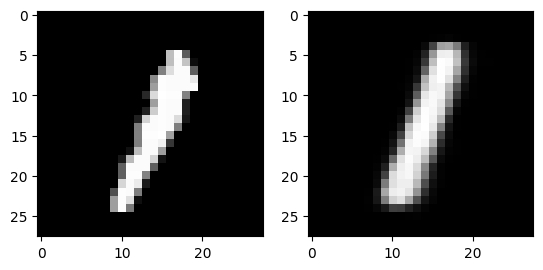

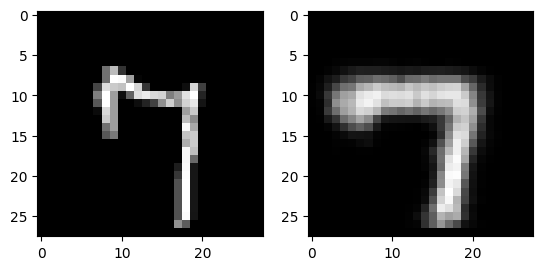

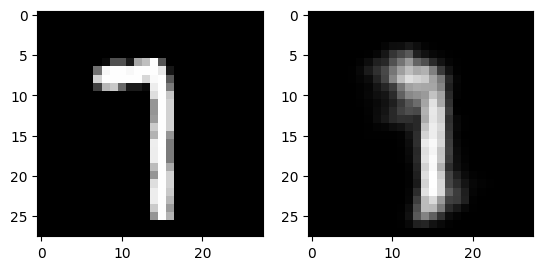

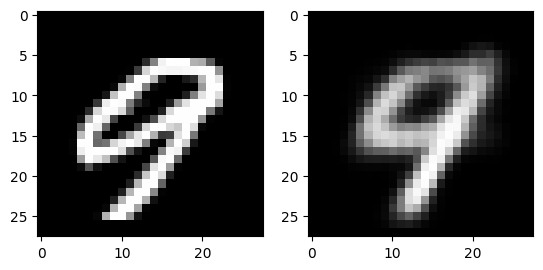

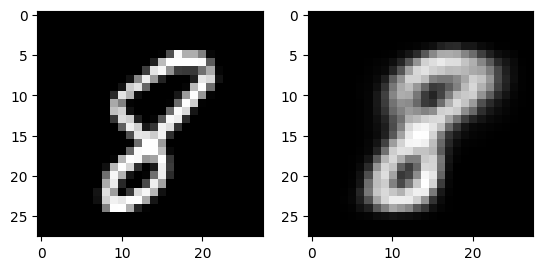

In [13]:
model.eval()
for i in range(5):
  images = next(iter(train_loader))

  images = images.to(device).unsqueeze(1).type(torch.float32) / 255
  reconstructed, mu, std = model(images)
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(images[0].permute(1,2,0).detach().cpu().numpy(), cmap="gray")
  axarr[1].imshow(reconstructed[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')

## Visualizing Distribution:

In [37]:
model.eval()
samples_x = []
samples_y = []

label = testset.targets[:5000]

for i in range(5000):
    image = testset.data[i]
    image = image.to(device).reshape(1,1,28,-1).type(torch.float32) / 255
    
    mu, std = model.encoder(image)
    sample = model.sampling(mu, std).squeeze()

    samples_x.append(sample[0].item())
    samples_y.append(sample[1].item())

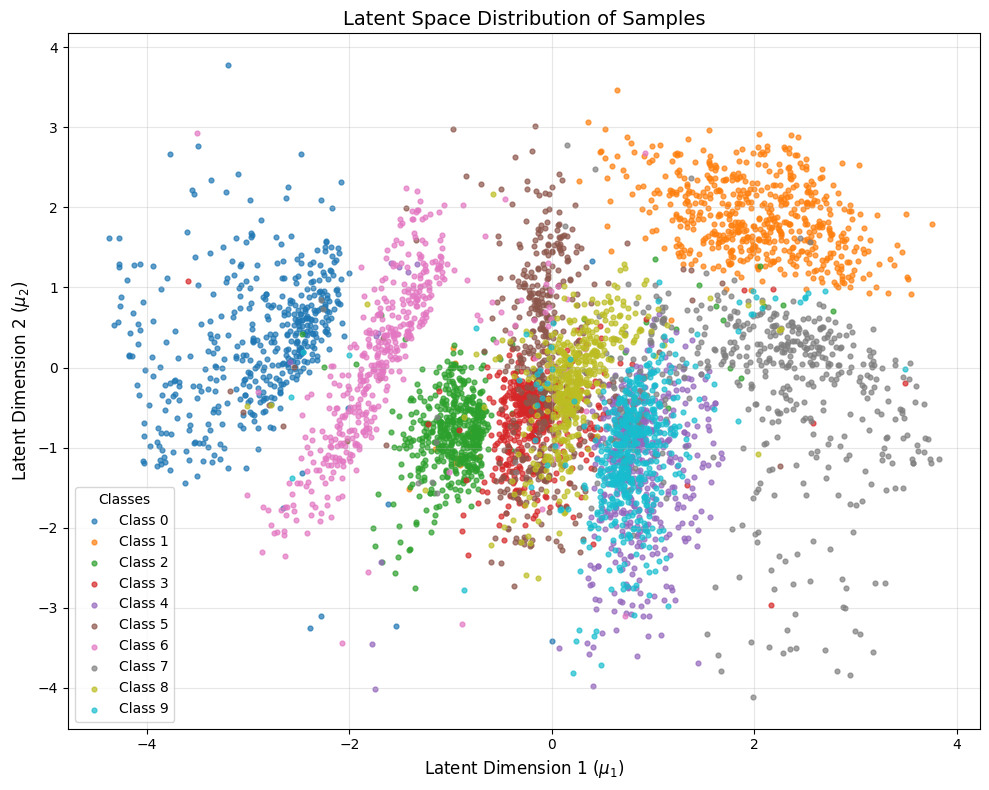

In [57]:
samples_x = np.array(samples_x)
samples_y = np.array(samples_y)
classes = np.unique(label)
colors = plt.get_cmap('tab10', len(classes))

plt.figure(figsize=(10, 8))
for class_idx in classes:
    
    class_mask = (label == class_idx)
    
    plt.scatter(samples_x[class_mask], 
                samples_y[class_mask],
                label=f'Class {class_idx}', 
                alpha=0.7, 
                s=12,
                c=[colors(class_idx)]) 

plt.title("Latent Space Distribution of Samples", fontsize=14)
plt.xlabel("Latent Dimension 1 ($\mu_1$)", fontsize=12)
plt.ylabel("Latent Dimension 2 ($\mu_2$)", fontsize=12)
plt.legend(title="Classes")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


# Measuring the quality of reconstructed images:

In [72]:
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to("cuda:1")

def compute_mae(denoised, ground_truth):
    mae = torch.mean(torch.abs(denoised - ground_truth))
    return mae

In [76]:
model.eval()
mae_loss = 0
ssim_similarity = 0
for images in test_loader:

    images = images.to(device).unsqueeze(1).type(torch.float32) / 255

    reconstructed_batch, mu, std = model(images)
    similarity = ssim_metric(reconstructed_batch, images)
    loss = compute_mae(reconstructed_batch, images) * 255
    
    mae_loss += loss.item()
    ssim_similarity += similarity.item()

ssim_similarity /= (len(test_loader))
mae_loss /= (len(test_loader))

print(f'SSIM of reconstructed images in Test set: {ssim_similarity:.4f}\nMAE loss: {mae_loss:.4f}')

SSIM of reconstructed images in Test set: 0.6617
MAE loss: 22.9751
